In [1]:
import tensorflow as tf
import os
import time
import scipy
import numpy as np
import shutil
from tqdm import tqdm
from main import layers,load_vgg,optimize

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0
Tests Passed
Tests Passed
Tests Passed


In [2]:
image_shape = (160, 576)

def predict_using_raw_model(l_image_file, 
                            model_file="./models_l2_norm_lr_1.00e-04_l2_1.00e-03_e10_batch_1/eproch_9_loss"):
    vgg_path = "./data/vgg/"
    num_classes = 2
    epochs = 50
    batch_size = 16
    tf.reset_default_graph()
    with tf.Session() as sess:
        correct_label = tf.placeholder(tf.int32, [None, None, None, num_classes])
        learning_rate = tf.placeholder(tf.float32)
    
        input_image, keep_prob, vgg_layer3_out, vgg_layer4_out, vgg_layer7_out = \
            load_vgg(sess, vgg_path)

        nn_last_layer = layers(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out, num_classes)

        logits, training_op, cross_entropy_loss = \
            optimize(nn_last_layer, correct_label, learning_rate, num_classes)
        
        saver = tf.train.Saver()
        saver.restore(sess, model_file)
        l_street_im = []
        for image_file in tqdm(l_image_file):
            image_raw = scipy.misc.imread(image_file)
            image_raw_shape = image_raw.shape[0:2]
            image = scipy.misc.imresize(image_raw, image_shape)
            im_softmax = sess.run(
                [tf.nn.softmax(logits)],
                {keep_prob: 1.0, input_image: [image]})
    
            im_softmax = im_softmax[0][:, 1].reshape(image_shape[0], image_shape[1])
            segmentation = (im_softmax > 0.5).reshape(image_shape[0], image_shape[1], 1)
            mask = np.dot(segmentation, np.array([[0, 255, 0, 127]]))
            mask = scipy.misc.imresize(mask, image_raw_shape)
            mask = scipy.misc.toimage(mask, mode="RGBA")
            street_im = scipy.misc.toimage(image_raw)
            #street_im = scipy.misc.toimage(image)
            street_im.paste(mask, box=None, mask=mask)
            l_street_im.append(street_im)
    
    return l_street_im

In [3]:
l_input_images = !ls ./data/data_road/testing/image_2/*.png
l_img = predict_using_raw_model(l_input_images)

INFO:tensorflow:Restoring parameters from b'./data/vgg/variables/variables'
INFO:tensorflow:Restoring parameters from ./models_l2_norm_lr_1.00e-04_l2_1.00e-03_e10_batch_1/eproch_9_loss


100%|██████████| 290/290 [00:38<00:00,  7.75it/s]


In [4]:
!mkdir -p ./runs/lr_1e4_l2_1e3_batch_1

In [5]:
save_path = "./runs/lr_1e4_l2_1e3_batch_1"
l_outname = [ "%s/%s" % (save_path, os.path.basename(x) )for x in l_input_images]
for i,outname in tqdm(enumerate(l_outname)):
    scipy.misc.imsave(outname, l_img[i])

290it [00:50,  5.52it/s]


In [6]:
def load_graph(graph_file, use_xla=False):
    jit_level = 0
    config = tf.ConfigProto()
    if use_xla:
        jit_level = tf.OptimizerOptions.ON_2
        config.graph_options.optimizer_options.global_jit_level = jit_level

    with tf.Session(graph=tf.Graph(), config=config) as sess:
        gd = tf.GraphDef()
        with tf.gfile.Open(graph_file, 'rb') as f:
            data = f.read()
            gd.ParseFromString(data)

        tf.import_graph_def(gd, name='')
        ops = sess.graph.get_operations()
        n_ops = len(ops)
        return sess, ops
    
def predict_using_graphdef_file(l_image_file, graph_file, use_xla=False):
    sess, _ = load_graph(graph_file, use_xla)
    graph = sess.graph
    image_input = graph.get_tensor_by_name("image_input:0")
    keep_prob   = graph.get_tensor_by_name("keep_prob:0")
    logit       = graph.get_tensor_by_name("predicted_label:0")
    l_street_im = []
    for image_file in tqdm(l_image_file):
        image = scipy.misc.imresize(scipy.misc.imread(image_file), image_shape)
        im_softmax = sess.run(
            [logit],
            {keep_prob: 1.0, image_input: np.expand_dims(image, axis=0)})
        
        im_softmax = im_softmax[0][:, 1].reshape(image_shape[0], image_shape[1])
        segmentation = (im_softmax > 0.5).reshape(image_shape[0], image_shape[1], 1)
        mask = np.dot(segmentation, np.array([[0, 255, 0, 127]]))
        mask = scipy.misc.toimage(mask, mode="RGBA")
        street_im = scipy.misc.toimage(image)
        street_im.paste(mask, box=None, mask=mask)
        l_street_im.append(street_im)
    
    return l_street_im
    

## Using some optimization

The optimized model ran faster, but the result seemed not so well as the origin model.

100%|██████████| 290/290 [00:26<00:00, 10.80it/s]


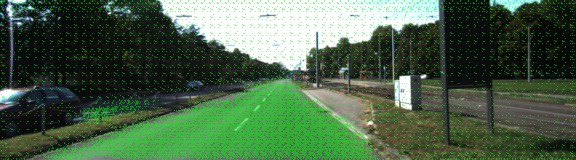

In [7]:
l_img = predict_using_graphdef_file(l_input_images, graph_file="./freezed_model/frozen_graph.pb")
l_img[0]

100%|██████████| 290/290 [00:26<00:00, 10.88it/s]


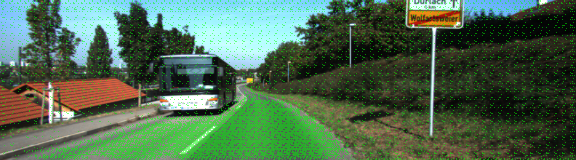

In [8]:
l_img = predict_using_graphdef_file(l_input_images, graph_file="./freezed_model/optimized_graph.pb")
l_img[32]

## One problem

8bit much slower. This has been reported as an issue on tensorflow github [https://github.com/tensorflow/tensorflow/issues/5757](https://github.com/tensorflow/tensorflow/issues/5757). 

100%|██████████| 3/3 [00:36<00:00, 12.16s/it]


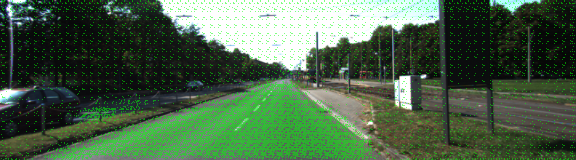

In [9]:
l_img = predict_using_graphdef_file(l_input_images[0:3], graph_file="./freezed_model/eightbit_graph.pb")
l_img[0]

100%|██████████| 3/3 [00:36<00:00, 12.14s/it]


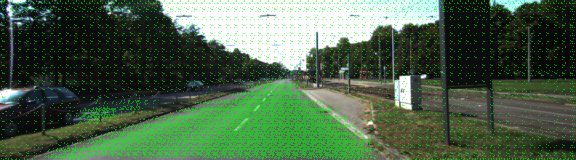

In [10]:
l_img = predict_using_graphdef_file(l_input_images[0:3], graph_file="./freezed_model/eightbit_graph.pb", use_xla=True)
l_img[0]

# Test on a video

In [11]:
#import imageio
#imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip

In [12]:
vgg_path = "./data/vgg/"
num_classes = 2
epochs = 50
batch_size = 16
model_file="./models_l2_norm_lr_1.00e-04_l2_1.00e-03_e10_batch_1/eproch_9_loss"
tf.reset_default_graph()
with tf.Session() as sess:
    correct_label = tf.placeholder(tf.int32, [None, None, None, num_classes])
    learning_rate = tf.placeholder(tf.float32)
    
    input_image, keep_prob, vgg_layer3_out, vgg_layer4_out, vgg_layer7_out = \
        load_vgg(sess, vgg_path)

    nn_last_layer = layers(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out, num_classes)

    logits, training_op, cross_entropy_loss = \
            optimize(nn_last_layer, correct_label, learning_rate, num_classes)
        
    saver = tf.train.Saver()
    saver.restore(sess, model_file)

    def parseImage(image_raw):
        image_raw_shape = image_raw.shape[0:2]
        image = scipy.misc.imresize(image_raw, image_shape)
        im_softmax = sess.run(
            [tf.nn.softmax(logits)],
             {keep_prob: 1.0, input_image: [image]})
    
        im_softmax = im_softmax[0][:, 1].reshape(image_shape[0], image_shape[1])
        segmentation = (im_softmax > 0.5).reshape(image_shape[0], image_shape[1], 1)
        mask = np.dot(segmentation, np.array([[0, 255, 0, 127]]))
        mask = scipy.misc.imresize(mask, image_raw_shape)
        mask = scipy.misc.toimage(mask, mode="RGBA")
        street_im = scipy.misc.toimage(image_raw)
        street_im.paste(mask, box=None, mask=mask)
        return np.array(street_im)
    

    #image_raw = scipy.misc.imread("./data/data_road/testing/image_2/um_000032.png")
    #outimg = parseImage(image_raw)
    clip = VideoFileClip("../../Project4_AdvancedLaneLines/CarND-Advanced-Lane-Lines/harder_challenge_video.mp4")
    proj_clip = clip.fl_image(parseImage)
    %time proj_clip.write_videofile("./hardchallenge_video.result.mp4", audio=False)
        

INFO:tensorflow:Restoring parameters from b'./data/vgg/variables/variables'
INFO:tensorflow:Restoring parameters from ./models_l2_norm_lr_1.00e-04_l2_1.00e-03_e10_batch_1/eproch_9_loss
[MoviePy] >>>> Building video ./hardchallenge_video.result.mp4
[MoviePy] Writing video ./hardchallenge_video.result.mp4


100%|█████████▉| 1199/1200 [02:53<00:00,  6.66it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./hardchallenge_video.result.mp4 

CPU times: user 2min 45s, sys: 11.7 s, total: 2min 57s
Wall time: 2min 54s


In [14]:
from IPython.display import HTML

HTML("""
<video width="960" height="540" controls>
    <source src="{0}">
</video>
""".format("./project_video.result.mp4"))